# Регуляризация нейронных сетей

---

В этом задании вам необходимо будет реализовать 2 подхода к регуляризации нейронных сетей через ограничения структуры:

*   Dropout
*   Batch normalization

После нужно будет понаблюдать, как они влияют на качество построенной нейронной сети на датасете **CIFAR-10** (Canadian Institute For Advanced Research).

CIFAR-10 состоит из 60k цветных изображений размером 32x32, разделенных на 10 классов, по 6k изображений на каждый класс (train - 50k, test - 10k).

*Подробнее про данные можно посмотреть [тут](https://www.cs.toronto.edu/~kriz/cifar.html)*





In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import trange

BATCH_SIZE = 64

Загрузим данные и посмотрим на них:

In [ ]:
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor()])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 79.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


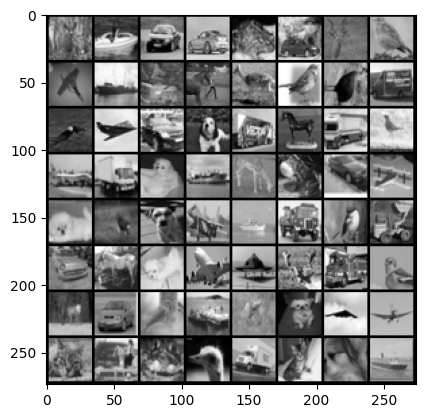

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

Переиспользуем классы из предыдущего занятия *с минорными изменениями*

In [ ]:
class Module:
    """
    Базовый класс для построения модулей нейронной сети.

    Этот класс предоставляет интерфейс для создания и использования модулей,
    составляющих нейронную сеть.  Он определяет основные методы, которые должны
    быть реализованы в каждом конкретном модуле.

    Attributes:
        mode (str): Режим работы модуля ('train' или 'test').
            Устанавливается с помощью метода set_mode. По умолчанию 'train'.

    Notes:
        Этот класс является абстрактным и не должен использоваться напрямую.
        Он предназначен для создания конкретных модулей нейронной сети, которые
        наследуются от него и реализуют необходимые методы.
    """

    def __init__(self):
        self.mode = 'train'

    def set_mode(self, mode: str) -> None:
        """
        Устанавливает режим работы модуля.

        Args:
            mode (str): Режим работы модуля ('train' или 'test').
        """

        assert mode in ['train', 'test']
        self.mode = mode

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Метод для прямого прохода

        Args:
            x (np.ndarray): Входные данные. Размерность может быть (batch_size,
              in_features) или (in_features,) для вектора.

        Returns:
            np.ndarray: Выходные данные после линейного преобразования
            (размерность: (batch_size, out_features) или (out_features,) для вектора).
        """
        pass

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """
        Метод для обратного прохода

        Args:
            gradient (np.ndarray): Градиент ошибки, полученный от следующего слоя.
            Размерность может быть (batch_size, out_features) или (out_features,)
            для вектора.

        Returns:
            np.ndarray: Градиент ошибки для предыдущего слоя
            (размерность: (batch_size, in_features) или (in_features,) для вектора).
        """
        pass

    def update(self, learning_rate: float) -> None:
        """
        Метод для обновления параметров модуля

        Args:
            learning_rate (float): Скорость обучения.
        """
        pass

In [ ]:
class Linear(Module):
    """
    Реализует полносвязный линейный слой.

    Этот слой выполняет линейное преобразование входных данных: y = xW + b,
    где W - матрица весов, b - вектор смещения, а x - входные данные.

    Args:
        in_features (int): Количество входных признаков.
        out_features (int): Количество выходных признаков.

    Attributes:
        bias (np.ndarray): Параметр сдвига (размер `out_features`).
        weight (np.ndarray): Параметры слоя (размер (`in_features`, `out_features`)).

    """

    def __init__(self, in_features, out_features):
        super().__init__()
        self.weights = np.random.normal(0, np.sqrt(2.0 / in_features), size=(in_features, out_features))
        self.bias = np.zeros(out_features)

        self.dweights = None
        self.dbias = None

        self.input = None

    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.bias

    def backward(self, gradient):
        dx = np.dot(gradient, self.weights.T)
        self.dweights = np.dot(self.input.T, gradient)
        self.dbias = np.sum(gradient, axis=0)
        return dx

    def update(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.dweights
        self.bias -= learning_rate * self.dbias

    def set_mode(self, mode: str) -> None:
        pass

In [ ]:
class ReLU(Module):
    def __init__(self):
        super().__init__()
        self.input = None

    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, gradient):
        drelu = np.where(self.input > 0, 1, 0)
        return gradient * drelu

    def update(self, learning_rate):
        pass

    def set_mode(self, mode: str) -> None:
        pass

In [ ]:
class Softmax(Module):
    def __init__(self):
        self.output = None

    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output

    def backward(self, gradient):
        return gradient

    def update(self, learning_rate):
        pass

    def set_mode(self, mode: str) -> None:
        pass

In [ ]:
class CrossEntropy:
    def __init__(self):
        self.true_labels = None
        self.pred_probs = None

    def forward(self, pred_probs, true_labels):
        self.true_labels = true_labels
        self.pred_probs = pred_probs
        pred_probs = np.clip(pred_probs, 1e-15, 1 - 1e-15)
        loss = -np.sum(true_labels * np.log(pred_probs)) / pred_probs.shape[0]
        return loss

    def backward(self):
        grad_output = (self.pred_probs - self.true_labels) / self.pred_probs.shape[0]
        return grad_output

In [ ]:
cross_entropy_loss = CrossEntropy()

# Задание 1: обучение полносвязной сети (1 балл)

Обучите полносвязную нейронную сеть на заданных данных и протестируйте ее на тестовом датасете

In [ ]:
class Net:
    """
    Реализация нейронной сети с использованием модульной структуры.

    Attributes:
        modules (list[Module]): Список модулей, составляющих сеть.
        learning_rate (float):  Скорость обучения, используемая при обновлении параметров модулей.
        max_iter (int): Максимальное количество эпох обучения.
    """

    def __init__(
            self,
            modules: list[Module],
            learning_rate: float = 0.001,
            max_iter: int = 10
            ):

        self.modules = modules
        self.learning_rate = learning_rate
        self.max_iter = max_iter

    def __set_mode(self, mode: str):
        """
        Устанавливает режим работы для каждого модуля в сети.

        Args:
            mode (str): Режим работы для каждого модуля ('train' или 'test').
        """

        for i in range(len(self.modules)):
            self.modules[i].set_mode(mode)

    def train(self, trainloader: DataLoader) -> None:
        """
        Обучает модель на заданных данных.

        Args:
            trainloader (DataLoader): Загрузчик данных,
            предоставляющий батчи обучающих данных.
        """
        self.__set_mode('train')

        cross_entropy = CrossEntropy()

        for epoch in range(self.max_iter):
            for data in trainloader:
                inputs, labels = data

                X_batch = inputs.numpy().reshape(inputs.shape[0], -1)
                y_batch = labels.numpy().reshape(labels.shape[0],)
                y_batch = self.one_hot_encode(y_batch.astype(int))

                y_pred = self.forward(X_batch)
                loss = cross_entropy.forward(y_pred, y_batch)
                grad_output = cross_entropy.backward()
                self.backward(grad_output)
                self.update()

            y_pred = self.forward(X_batch)
            loss = cross_entropy.forward(y_pred, y_batch)

            print(f"Epoch [{epoch + 1}/{self.max_iter}], Train data Loss: {loss:.4f}")


    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Делает предсказание на заданных входных данных.

        Args:
            X (np.ndarray): Матрица входных данных.

        Returns:
            np.ndarray: Матрица предсказанных значений.
        """

        self.__set_mode('test')

        y_pred = self.forward(X)
        return y_pred

    def forward(self, x):
        for module in self.modules:
            x = module.forward(x)
        return x

    def backward(self, grad_output):
        for module in reversed(self.modules):
            grad_output = module.backward(grad_output)

    def update(self):
        for module in self.modules:
            module.update(self.learning_rate)

    def one_hot_encode(self, y: np.ndarray) -> np.ndarray:
        num_classes = 10
        y_one_hot = np.zeros((y.shape[0], num_classes))
        y_one_hot[np.arange(y.shape[0]), y] = 1
        return y_one_hot

## Обучение модели без нормализации:

In [ ]:
net = Net(
    modules=[
        Linear(1024, 512),
        ReLU(),
        Linear(512, 256),
        ReLU(),
        Linear(256, 128),
        ReLU(),
        Linear(128, 10),
        ReLU(),
        Softmax()
    ],
    learning_rate = 0.01,
    max_iter = 20
)

Функция для тестирования

In [ ]:
def calculate_accuracy(model: Net, dataloader: DataLoader) -> float:
  """
  Вычисляет точность модели на заданном даталоадере.

  Args:
    model (Net): Модель для тестирования.
    dataloader (DataLoader): Загрузчик данных, предоставляющий батчи тестовых данных.

  Returns:
    float: Accuarcy.
  """
  correct = 0
  total = 0

  for data in dataloader:
    inputs, labels = data
    inputs = inputs.numpy()
    inputs = inputs.reshape(inputs.shape[0], -1)

    outputs = model.predict(inputs)
    predicted = np.argmax(outputs, axis=1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  return correct / total

### Точность:

In [ ]:
calculate_accuracy(net, testloader)

0.3329

# Задание 2: Dropout (2 балла)

Реализуйте слой Dropout.

In [ ]:
class Dropout(Module):
    """
    Реализует слой Dropout для регуляризации нейронной сети.

    Dropout случайным образом обнуляет нейроны входного слоя во время обучения,
    чтобы предотвратить переобучение.  Во время тестирования, слой Dropout
    не влияет на входные данные, просто пропуская их без изменений.

    Args:
        p (float): Вероятность того, что нейрон будет обнулен.
                   Значение должно быть между 0 и 1. По умолчанию 0.1.
    """

    def __init__(self, p: float = 0.1):
        super().__init__()
        self.p = p
        self.mask = None
        self.mode = None

    def forward(self, x: np.ndarray) -> np.ndarray:
      if self.mode == 'train':
          self.mask = (np.random.rand(*x.shape) > self.p).astype(float)
          self.mask /= (1 - self.p)
          return x * self.mask
      elif self.mode == 'test':
          return x
      else:
          raise ValueError(f'Invalid mode: {self.mode}')

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        if self.mode == "train":
            return gradient * self.mask
        elif self.mode == "test":
            return gradient
        else:
            raise ValueError(f"Invalid mode: {self.mode}.")

    def update(self, learning_rate: float) -> None:
        pass

    def set_mode(self, mode: str) -> None:
        self.mode = mode

## Обучение модели с Dropout регуляризацией:

In [ ]:
net_drop_out = Net(
    modules=[
        Linear(1024, 512),
        ReLU(),
        Dropout(0.2),
        Linear(512, 256),
        ReLU(),
        Dropout(0.2),
        Linear(256, 128),
        ReLU(),
        Dropout(0.2),
        Linear(128, 10),
        ReLU(),
        Softmax()
    ],
    learning_rate = 0.01,
    max_iter = 20
)

In [ ]:
net_drop_out.train(trainloader)

Epoch [1/20], Train data Loss: 2.2486
Epoch [2/20], Train data Loss: 2.1804
Epoch [3/20], Train data Loss: 2.1044
Epoch [4/20], Train data Loss: 1.9141
Epoch [5/20], Train data Loss: 1.9949
Epoch [6/20], Train data Loss: 2.0281
Epoch [7/20], Train data Loss: 1.8877
Epoch [8/20], Train data Loss: 1.7456
Epoch [9/20], Train data Loss: 1.5351
Epoch [10/20], Train data Loss: 2.1257
Epoch [11/20], Train data Loss: 1.5385
Epoch [12/20], Train data Loss: 1.5851
Epoch [13/20], Train data Loss: 1.9392
Epoch [14/20], Train data Loss: 1.5543
Epoch [15/20], Train data Loss: 1.6920
Epoch [16/20], Train data Loss: 1.9086
Epoch [17/20], Train data Loss: 1.6111
Epoch [18/20], Train data Loss: 1.8291
Epoch [19/20], Train data Loss: 1.2569
Epoch [20/20], Train data Loss: 1.7608


## Точность:

In [ ]:
calculate_accuracy(net_drop_out, testloader)

0.39

## При точно той же архитектуре сети и гиперпараметрах добавление Dropout нормализации заметно улучшило точность классификации.

# Задание 3: Batch Normalization (4 балла)

Реализуйте слой Batch Normalization для одномерного случая.

Формулы для обратного прохода можно найти в оригинальной [статье](https://arxiv.org/abs/1502.03167).

*Подсказка:* вот [разбор](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html) того, как работает метод обратного распространения ошибки в слое batch normalization.


In [ ]:
class BatchNorm1d(Module):
    """
    Реализует слой Batch Normalization для 1D данных.

    Batch Normalization нормализует активации каждого батча данных,
    чтобы ускорить обучение и улучшить обобщающую способность модели.

    Во время обучения вычисляются среднее и дисперсия для каждого мини-пакета,
    которые используются для нормализации.  Кроме того, вычисляются скользящие
    средние этих статистик для использования во время инференса.

    Args:
        in_features (int): Количество входных признаков.
        eps (float): Небольшое значение, добавленное к дисперсии для
                     предотвращения деления на ноль. По умолчанию 1e-5.
        lamda (float): Фактор затухания для вычисления скользящих средних
                      среднего и дисперсии. По умолчанию 0.9.

    Attributes:
        eps (float): Небольшое значение для предотвращения деления на ноль.
        lamda (float): Фактор затухания для скользящих средних.

        gamma (np.ndarray): Масштабируемый параметр (размер `in_features`).
        beta (np.ndarray): Параметр сдвига (размер `in_features`).

        running_mean (np.ndarray): Скользящее среднее среднего (размер `in_features`).
        running_var (np.ndarray): Скользящее среднее дисперсии (размер `in_features`).
    """

    def __init__(self, in_features: int, eps: float = 1e-5, lamda: float = 0.9):
        super().__init__()
        self.eps = eps
        self.lamda = lamda

        self.gamma = np.random.randn(in_features)
        self.beta = np.zeros(in_features)

        self.running_mean = np.zeros(in_features)
        self.running_var = np.zeros(in_features)

        self.cache = {}
        self.mode = None


    def forward(self, x: np.ndarray) -> np.ndarray:
        if self.mode == 'train':
            batch_mean = np.mean(x, axis=0)
            batch_var = np.var(x, axis=0)

            self.running_mean = self.lamda * self.running_mean + (1 - self.lamda) * batch_mean
            self.running_var = self.lamda * self.running_var + (1 - self.lamda) * batch_var

            x_hat = (x - batch_mean) / np.sqrt(batch_var + self.eps)

            self.cache = {
                'x': x,
                'x_hat': x_hat,
                'batch_mean': batch_mean,
                'batch_var': batch_var,
            }
        elif self.mode == 'test':
            x_hat = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
        else:
            raise ValueError(f'Invalid mode: {self.mode}')

        out = self.gamma * x_hat + self.beta
        return out


    def backward(self, gradient: np.ndarray) -> np.ndarray:
        x, x_hat, batch_mean, batch_var = self.cache['x'], self.cache['x_hat'], self.cache['batch_mean'], self.cache['batch_var']
        m = x.shape[0]

        self.dgamma = np.sum(gradient * x_hat, axis=0)
        self.dbeta = np.sum(gradient, axis=0)
        dx_hat = gradient * self.gamma

        dvar = np.sum(dx_hat * (x - batch_mean) * -0.5 * (batch_var + self.eps) ** (-1.5), axis=0)
        dmean = np.sum(dx_hat * -1 / np.sqrt(batch_var + self.eps), axis=0) + dvar * np.sum(-2 * (x - batch_mean), axis=0) / m

        dx = dx_hat / np.sqrt(batch_var + self.eps) + dvar * 2 * (x - batch_mean) / m + dmean / m
        return dx


    def update(self, learning_rate: float) -> None:
        self.gamma -= learning_rate * self.dgamma
        self.beta -= learning_rate * self.dbeta

    def set_mode(self, mode: str) -> None:
        self.mode = mode

# Задание 4: Обучение полносвязной сети с регуляризацией (3 балла)

Обучите полносвязную нейронную сеть на заданных данных с использованием слоев Dropout и Batch normalization, реализованных в предыдущих заданиях. Протестируйте полученную модель на тестовом датасете.

##Добавим в предыдущую модель Batch нормализацию:

In [ ]:
net_norm_2 = Net(
    modules=[
        Linear(1024, 512),
        BatchNorm1d(512),
        ReLU(),
        Dropout(0.2),
        Linear(512, 256),
        BatchNorm1d(256),
        ReLU(),
        Dropout(0.2),
        Linear(256, 10),
        ReLU(),
        Softmax()
    ],
    learning_rate = 0.01,
    max_iter = 20
)

In [ ]:
net_norm_2.train(trainloader)

Epoch [1/20], Train data Loss: 1.8566
Epoch [2/20], Train data Loss: 1.8859
Epoch [3/20], Train data Loss: 1.9954
Epoch [4/20], Train data Loss: 1.5963
Epoch [5/20], Train data Loss: 1.6018
Epoch [6/20], Train data Loss: 1.4878
Epoch [7/20], Train data Loss: 1.4877
Epoch [8/20], Train data Loss: 1.8280
Epoch [9/20], Train data Loss: 1.7143
Epoch [10/20], Train data Loss: 1.7100
Epoch [11/20], Train data Loss: 1.6446
Epoch [12/20], Train data Loss: 1.4829
Epoch [13/20], Train data Loss: 1.2395
Epoch [14/20], Train data Loss: 1.6905
Epoch [15/20], Train data Loss: 1.1869
Epoch [16/20], Train data Loss: 1.1413
Epoch [17/20], Train data Loss: 1.8183
Epoch [18/20], Train data Loss: 1.6454
Epoch [19/20], Train data Loss: 0.9952
Epoch [20/20], Train data Loss: 1.6231


## Точность:

In [ ]:
calculate_accuracy(net_norm_2, testloader)

0.4311

## Добавление Batch нормализации в предыдущую модель позволило увеличить точность классификации

## Обучим нейронную сеть с Dropout и Batch нормализациями с дополнительными слоями и большим количеством эпох:

In [ ]:
net_norm_4 = Net(
    modules=[
        Linear(1024, 1024),
        BatchNorm1d(1024),
        ReLU(),
        Dropout(0.3),
        Linear(1024, 512),
        BatchNorm1d(512),
        ReLU(),
        Dropout(0.3),
        Linear(512, 256),
        BatchNorm1d(256),
        ReLU(),
        Linear(256, 10),
        ReLU(),
        Softmax()
    ],
    learning_rate = 0.02,
    max_iter = 100
)

In [ ]:
net_norm_4.train(trainloader)

Epoch [1/100], Train data Loss: 1.9158
Epoch [2/100], Train data Loss: 1.7854
Epoch [3/100], Train data Loss: 1.5145
Epoch [4/100], Train data Loss: 1.7419
Epoch [5/100], Train data Loss: 1.7333
Epoch [6/100], Train data Loss: 1.5382
Epoch [7/100], Train data Loss: 1.7302
Epoch [8/100], Train data Loss: 1.1471
Epoch [9/100], Train data Loss: 1.5879
Epoch [10/100], Train data Loss: 1.5555
Epoch [11/100], Train data Loss: 1.0532
Epoch [12/100], Train data Loss: 1.0482
Epoch [13/100], Train data Loss: 1.2994
Epoch [14/100], Train data Loss: 1.2621
Epoch [15/100], Train data Loss: 1.3367
Epoch [16/100], Train data Loss: 1.4044
Epoch [17/100], Train data Loss: 1.2665
Epoch [18/100], Train data Loss: 1.4637
Epoch [19/100], Train data Loss: 1.4635
Epoch [20/100], Train data Loss: 1.0799
Epoch [21/100], Train data Loss: 1.3441
Epoch [22/100], Train data Loss: 1.4582
Epoch [23/100], Train data Loss: 1.4675
Epoch [24/100], Train data Loss: 1.3937
Epoch [25/100], Train data Loss: 1.3973
Epoch [26

## Точность:

In [ ]:
calculate_accuracy(net_norm_4, testloader)

0.4967

## Благодаря увеличенной глубине и ширине нейронная сеть показала результат еще лучше. Пока что это лучший результат, который удалось получить. Почти 50 процентов точности классификации изображений для линейной сети это неплохой результат.

## По результатам, полуенных разными сетями, виден эффект использоваия техник нормализации. Dropout нормализация позволяет избежать переобучение и улучшить точность на данных, которую нейросеть не видела при обучении. Batch нормализация хорошо показала себя в относительно большой сети.

# Домашнее задание № 3

Выполните задания в этом ноутбуке, а также продемонстируйте влияние регуляризации на построенную модель. Напишите полученные выводы.

ВАЖНО: PyTorch можно использовать только для работы с данными.

+ Мягкий дедлайн: `12.02.25 23:59`
+ Жесткий дедлайн: `19.02.25 23:59` (половина баллов)


После жесткого дедлайна задание не принимается.